In [29]:
import pyscf
from pyscf.tools import cubegen
import matplotlib.pyplot as plt
import numpy as np
import pyscf.lo as lo
import seaborn as sns
import pyscf.fci
import pandas as pd
import numpy as np
N=2
r=3.0
mol = pyscf.gto.M(
atom=";". join( f"H 0. 0. {i*r}" for i in range(N)),
basis='ccpvtz',
unit='B'
)

mf = pyscf.scf.RHF(mol)

mf.kernel()

cisolver = pyscf.fci.FCI(mf)
nroots=6
cisolver.nroots=nroots
energy, civec = cisolver.kernel()
energy

converged SCF energy = -0.988591417686438


array([-1.05526297, -0.97122363, -0.73612113, -0.63218492, -0.54135847,
       -0.47493169])

# Figure out what part of the Hamiltonian to keep

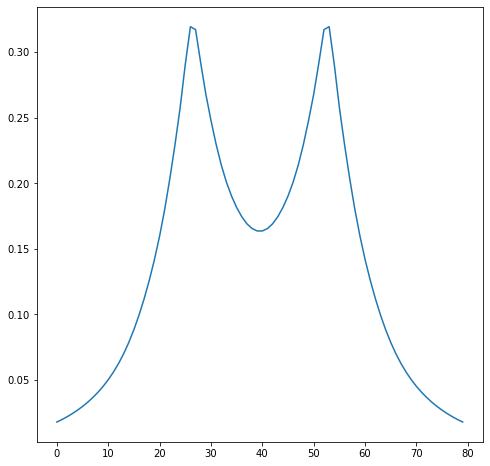

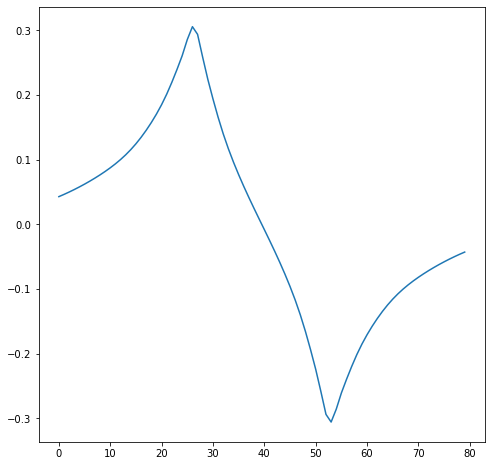

In [30]:
def plot_density_line(density):
    plt.figure(figsize=(8,8))
    cm = plt.plot(np.arange(density.shape[2]), density[density.shape[0]//2,density.shape[1]//2,:])
density = cubegen.orbital(mol, 'mo1.cube', mf.mo_coeff[:,0])
plot_density_line(density)
density = cubegen.orbital(mol, 'mo1.cube', mf.mo_coeff[:,1])
plot_density_line(density)

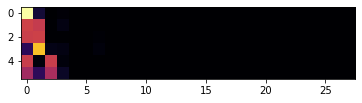

In [31]:
diags = [cisolver.make_rdm1(civec[i], norb=mf.mo_coeff.shape[0], nelec=2).diagonal() for i in range(nroots)]
plt.imshow(diags, cmap='inferno')
#plt.colorbar()

In [32]:
# Compute physical descriptors

In [33]:
R = np.array([[1,1],[1,-1]])/np.sqrt(2)
roots_keep = [0,1,2,3]

data = []
for i in roots_keep:
    for j in roots_keep:
        (u1, d1), (uu, ud,du, dd) = cisolver.trans_rdm12s( civec[i], civec[j], norb=mf.mo_coeff.shape[1], nelec=(1,1))

        u1 = np.einsum('ij,ai,bj->ab',u1[0:2,:][:,0:2],R,R)
        d1 = np.einsum('ij,ai,bj->ab',d1[0:2,:][:,0:2],R,R)
        ud = np.einsum("ijkl, ai, bj, ck, dl -> abcd", ud[0:2,0:2, 0:2, 0:2], R, R, R, R)
        #print(i,j, u1[0:2,:][:,0:2])
        E0 = 1

        en = energy[i]
        if i!=j:
            en=0
            E0=0

        

        data.append({'en':en,
              't1':u1[0,1]+ u1[1,0]+d1[0,1]+d1[1,0],
              'U': ud[0,0,0,0] + ud[1,1,1,1],
              'E0':E0,
              'trace':np.trace(u1)+np.trace(d1),
              'i':i,
              'j':j})

df = pd.DataFrame(data)
df


,en,t1,U,E0,trace,i,j
0,-1.055263,1.618716e+00,2.265925e-01,1,1.960049e+00,0,0
1,0.000000,-5.195389e-11,-3.466879e-11,0,1.523571e-10,0,1
2,0.000000,-1.728584e-11,-3.508638e-12,0,-6.016687e-12,0,2
3,0.000000,-1.048124e+00,-3.899600e-01,0,-4.167556e-02,0,3
4,0.000000,-5.195389e-11,-3.466878e-11,0,1.523571e-10,1,0
5,-0.971224,5.094368e-02,9.138784e-21,1,1.925328e+00,1,1
6,0.000000,2.664535e-15,-2.725597e-14,0,-6.938894e-14,1,2
7,0.000000,1.389946e-09,5.966415e-11,0,-2.062197e-09,1,3
8,0.000000,-1.728584e-11,-3.508749e-12,0,-6.016687e-12,2,0
9,0.000000,2.664535e-15,-2.725597e-14,0,-6.938894e-14,2,1


# Fit the effective Hamiltonian

In [34]:
import statsmodels.formula.api as sm
def fit_plot(string ="en ~ t1 + U + E0 -1" ):
    fit = sm.ols(string, data =df ).fit()
    print(fit.summary())
    dfnew = df.copy()
    dfnew['predict'] = fit.predict(dfnew)
    sns.regplot('en','predict', data=dfnew)
    return fit


                                 OLS Regression Results                                
Dep. Variable:                     en   R-squared (uncentered):                   0.981
Model:                            OLS   Adj. R-squared (uncentered):              0.978
Method:                 Least Squares   F-statistic:                              356.1
Date:                Thu, 23 Jun 2022   Prob (F-statistic):                    9.89e-13
Time:                        14:11:05   Log-Likelihood:                          22.284
No. Observations:                  16   AIC:                                     -40.57
Df Residuals:                      14   BIC:                                     -39.02
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/opt/homebrew/Caskroom/miniconda/base/envs/rosetta3.9/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/opt/homebrew/Caskroom/miniconda/base/envs/rosetta3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


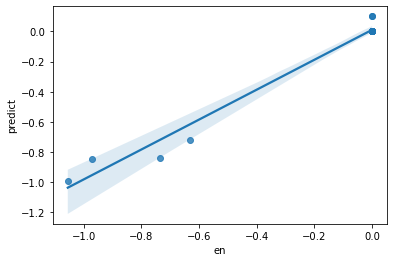

In [35]:
fit_plot("en~t1+E0-1")

                                 OLS Regression Results                                
Dep. Variable:                     en   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                              7875.
Date:                Thu, 23 Jun 2022   Prob (F-statistic):                    1.97e-21
Time:                        14:12:16   Log-Likelihood:                          50.738
No. Observations:                  16   AIC:                                     -95.48
Df Residuals:                      13   BIC:                                     -93.16
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

/opt/homebrew/Caskroom/miniconda/base/envs/rosetta3.9/lib/python3.9/site-packages/scipy/stats/stats.py:1541: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=16
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
/opt/homebrew/Caskroom/miniconda/base/envs/rosetta3.9/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


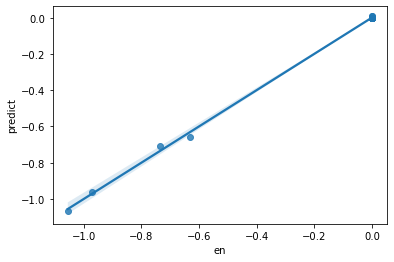

In [36]:
fit = fit_plot("en~t1+U+E0-1")

# Solving the Hubbard model and comparison to ab-initio

converged SCF energy = -0.0771347873184564


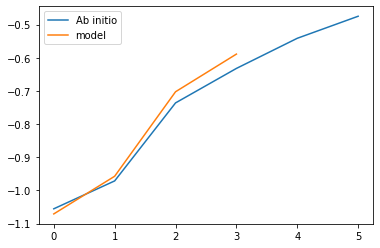

In [37]:
def solve_hubbard(t,U, E0):
    mol = pyscf.gto.M()
    n = 2
    mol.nelectron = n

    mf = pyscf.scf.RHF(mol)
    h1 = np.zeros((n,n))
    for i in range(n-1):
        h1[i,i+1] = h1[i+1,i] = t
    eri = np.zeros((n,n,n,n))
    for i in range(n):
        eri[i,i,i,i] = U

    mf.get_hcore = lambda *args: h1
    mf.get_ovlp = lambda *args: np.eye(n)
    mf._eri = pyscf.ao2mo.restore(8, eri, n)

    mf.kernel()
    mol.incore_anyway = True
    cisolver = pyscf.fci.FCI(mf)
    nroots=4
    cisolver.nroots=nroots
    energy, civec = cisolver.kernel()
    return energy + E0

plt.plot(energy, label='Ab initio')
plt.plot(solve_hubbard(fit.params['t1'], fit.params['U'], fit.params['E0']), label='model')
plt.legend()

## Comparison to tight-binding from HF

Note that $t$ is very much renormalized by interactions. 

In [38]:
H = np.array([[mf.mo_energy[0],0],[0,mf.mo_energy[1]]])
H_tb = np.einsum("ij,jk,kl->il", R,H,R)
print(H_tb)

[[-0.20598943 -0.22342047]
 [-0.22342047 -0.20598943]]
